In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

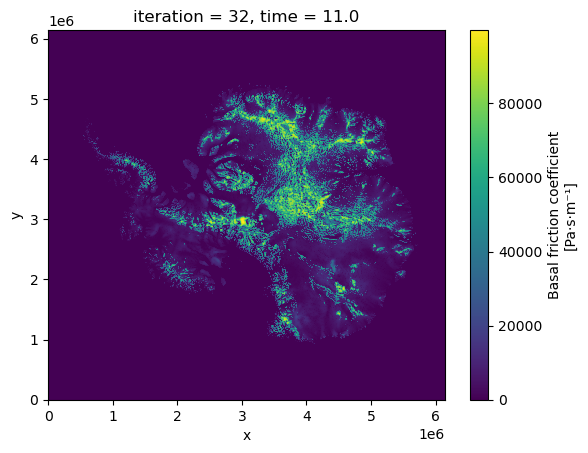

In [4]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/run001_Cwshelf_3lev_11.nc')
file.Cwshelf.isel(iteration=-1, time=-1).plot()

In [13]:
ppe = Path("/Users/jonniebarnsley/Downloads/ppe")

In [14]:
obs_path = Path("/Users/jonniebarnsley/data/MEaSUREs/MEaSUREs_antarctica_ice_velocity_v2_8km.nc")

with xr.open_dataset(obs_path) as f:
    obs = np.hypot(f.VX, f.VY)

In [33]:
def get_misfit(run: str):

    u = xr.open_dataset(ppe / 'xVel' / f'ppe_{run}_xVel_0lev.nc').xVel
    v = xr.open_dataset(ppe / 'yVel' / f'ppe_{run}_yVel_0lev.nc').yVel
    speed = np.hypot(u, v)
    spatial = abs(speed - obs)

    return spatial.sum(dim=('x', 'y'))

In [34]:
misfit = {}
for i in range(1, 17):
    print("doing run", i)
    run = f"run{i:02d}"
    misfit[i] = get_misfit(run)

doing run 1
doing run 2
doing run 3
doing run 4
doing run 5
doing run 6
doing run 7
doing run 8
doing run 9
doing run 10
doing run 11
doing run 12
doing run 13
doing run 14
doing run 15
doing run 16


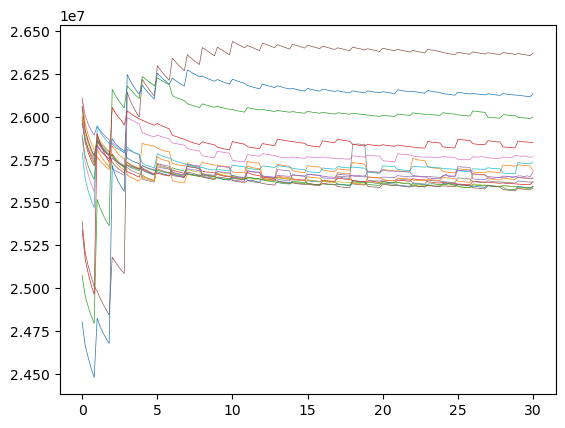

In [36]:
for i, ts in misfit.items():
    plt.plot(ts.time, ts, lw=0.5)

In [43]:
def gradient_norm(da, dim_x='x', dim_y='y'):
    # Compute spacing
    dx = da[dim_x].diff(dim_x).mean().item()
    dy = da[dim_y].diff(dim_y).mean().item()
    
    # Compute gradients along specified dims
    grad_y, grad_x = np.gradient(da.values, dy, dx, axis=(da.get_axis_num(dim_y), da.get_axis_num(dim_x)))
    
    # Gradient norm
    norm = np.sqrt(grad_x**2 + grad_y**2)

    # Return as DataArray with original coords and dims
    return xr.DataArray(norm, coords=da.coords, dims=da.dims, name="gradient_norm")


def get_solution_norms(run: str):

    Cwshelf = xr.open_dataset(ppe / 'Cwshelf' / f'ppe_{run}_Cwshelf_0lev.nc').Cwshelf
    muCoef = xr.open_dataset(ppe / 'muCoef' / f'ppe_{run}_muCoef_0lev.nc').muCoef

    gradC = gradient_norm(Cwshelf)
    gradmu = gradient_norm(muCoef)

    return gradC.sum(dim=('x', 'y')), gradmu.sum(dim=('x', 'y'))

In [57]:
norms = {}
for i in range(1, 17):
    print(f"doing run {i}")
    run = f"run{i:02d}"
    gradC, gradmu = get_solution_norms(run)
    norms[run] = (gradC, gradmu)

doing run 1
doing run 2
doing run 3
doing run 4
doing run 5
doing run 6
doing run 7
doing run 8
doing run 9
doing run 10
doing run 11
doing run 12
doing run 13
doing run 14
doing run 15
doing run 16


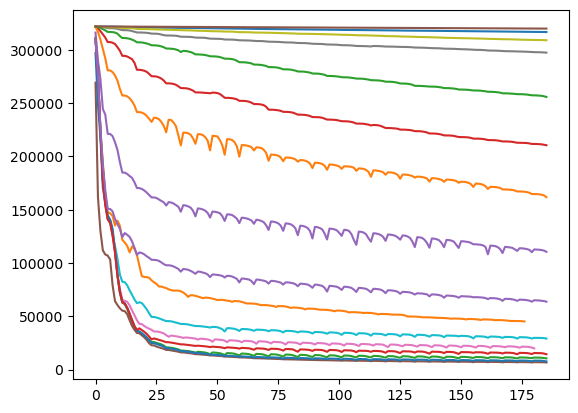

In [59]:
for i in range(1, 17):
    gradC, gradmu = norms[f'run{i:02d}']
    plt.plot(range(len(gradC)), gradC)

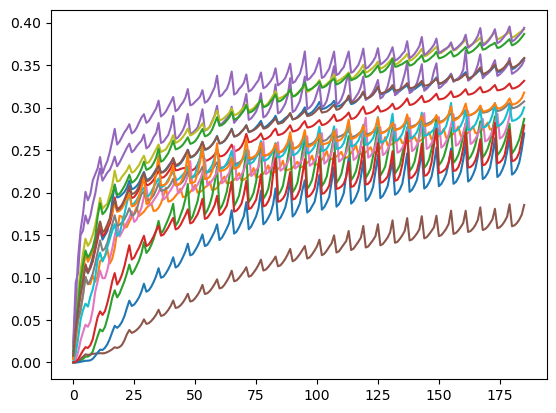

In [60]:
for i in range(1, 17):
    gradC, gradmu = norms[f'run{i:02d}']
    plt.plot(range(len(gradC)), gradmu)

In [8]:
import re
from pathlib import Path
from typing import Dict, List

def extract_misfit_norms_from_cg_files(cg_directory: str = "~/Downloads/CG") -> Dict[str, List[float]]:
    """
    Extract misfit norm values from CG optimization output files using regex.
    
    Args:
        cg_directory: Path to directory containing CG output files
        
    Returns:
        Dictionary mapping filename to list of misfit norm values
    """
    cg_path = Path(cg_directory).expanduser()
    misfit_norms = {}
    
    # Regex pattern to match norm values from CGOptimize output lines
    # Example: "CGOptimize iteration 1 ||f'(x)||^2 = 1.14828e+22 ||fm(x)||^2 = 4.14777e+16 ||fp(x)||^2 = 3.5087e+13"
    # We want to extract the ||fm(x)||^2 values
    norm_patterns = [
        r'\|\|fm\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)',  # ||fm(x)||^2 = value
        r'\|\|fm\(x\)\|\|\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)',     # ||fm(x)|| = value (without ^2)
        r'CGOptimize.*?\|\|fm\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)'  # Full line context
    ]
    
    if not cg_path.exists():
        print(f"Directory {cg_path} does not exist")
        return misfit_norms
    
    # Process all files in the CG directory
    for file_path in cg_path.iterdir():
        if file_path.is_file():
            try:
                print(f"Processing file: {file_path.name}")
                
                # Read file content
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                
                # Extract norm values using all patterns
                norms = []
                for pattern in norm_patterns:
                    matches = re.findall(pattern, content, re.IGNORECASE)
                    for match in matches:
                        try:
                            norm_value = float(match)
                            norms.append(norm_value)
                        except ValueError:
                            continue
                
                # Store results if any norms were found
                if norms:
                    misfit_norms[file_path.name] = norms
                    print(f"  Found {len(norms)} norm values")
                else:
                    print(f"  No norm values found")
                    
            except Exception as e:
                print(f"Error processing {file_path.name}: {e}")
    
    return misfit_norms

# Extract misfit norms from CG files
cg_misfit_norms = extract_misfit_norms_from_cg_files()

# Display results
print(f"\nExtracted norms from {len(cg_misfit_norms)} files:")
for filename, norms in cg_misfit_norms.items():
    print(f"{filename}: {len(norms)} values")
    if norms:
        print(f"  Range: {min(norms):.2e} to {max(norms):.2e}")
        print(f"  Final value: {norms[-1]:.2e}")


Processing file: run16_CG.txt
  Found 3318 norm values
Processing file: run08_CG.txt
  Found 5648 norm values
Processing file: run04_CG.txt
  Found 5812 norm values
Processing file: run06_CG.txt
  Found 2826 norm values
Processing file: run14_CG.txt
  Found 3148 norm values
Processing file: run10_CG.txt
  Found 3462 norm values
Processing file: run02_CG.txt
  Found 3374 norm values
Processing file: run12_CG.txt
  Found 4012 norm values
Processing file: run09_CG.txt
  Found 2840 norm values
Processing file: run05_CG.txt
  Found 2596 norm values
Processing file: run07_CG.txt
  Found 2740 norm values
Processing file: run15_CG.txt
  Found 2606 norm values
Processing file: run11_CG.txt
  Found 2790 norm values
Processing file: run03_CG.txt
  Found 2788 norm values
Processing file: run01_CG.txt
  Found 3840 norm values
Processing file: run13_CG.txt
  Found 3010 norm values

Extracted norms from 16 files:
run16_CG.txt: 3318 values
  Range: 1.72e+15 to 6.80e+16
  Final value: 1.72e+15
run08_CG

In [9]:
# Additional analysis and visualization of extracted misfit norms
import matplotlib.pyplot as plt

def plot_misfit_convergence(misfit_norms: Dict[str, List[float]], max_plots: int = 10):
    """
    Plot convergence curves for misfit norms from different runs.
    
    Args:
        misfit_norms: Dictionary of filename -> list of norm values
        max_plots: Maximum number of files to plot (to avoid cluttered plots)
    """
    if not misfit_norms:
        print("No misfit norms to plot")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Plot up to max_plots files
    files_to_plot = list(misfit_norms.keys())[:max_plots]
    
    for filename in files_to_plot:
        norms = misfit_norms[filename]
        iterations = range(len(norms))
        plt.semilogy(iterations, norms, marker='o', markersize=3, 
                    linewidth=1, label=filename, alpha=0.8)
    
    plt.xlabel('Iteration')
    plt.ylabel('Misfit Norm (log scale)')
    plt.title('Convergence of Misfit Norms from CG Optimization')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def get_convergence_stats(misfit_norms: Dict[str, List[float]]) -> Dict[str, Dict]:
    """
    Calculate convergence statistics for each run.
    
    Returns:
        Dictionary with convergence statistics for each file
    """
    stats = {}
    
    for filename, norms in misfit_norms.items():
        if len(norms) < 2:
            continue
            
        initial_norm = norms[0]
        final_norm = norms[-1]
        reduction_factor = initial_norm / final_norm if final_norm > 0 else float('inf')
        reduction_ratio = (initial_norm - final_norm) / initial_norm if initial_norm > 0 else 0
        
        stats[filename] = {
            'iterations': len(norms),
            'initial_norm': initial_norm,
            'final_norm': final_norm,
            'reduction_factor': reduction_factor,
            'reduction_ratio': reduction_ratio,
            'converged': final_norm < 1e-6  # Arbitrary convergence threshold
        }
    
    return stats

# Note: Plotting and analysis will be done in the next cell after data extraction


Extracting detailed CGOptimize data...
Processing file: run16_CG.txt
  Found 1659 CGOptimize lines
  ||fm(x)||^2 values: 1659
Processing file: run08_CG.txt
  Found 2824 CGOptimize lines
  ||fm(x)||^2 values: 2824
Processing file: run04_CG.txt
  Found 2906 CGOptimize lines
  ||fm(x)||^2 values: 2906
Processing file: run06_CG.txt
  Found 1413 CGOptimize lines
  ||fm(x)||^2 values: 1413
Processing file: run14_CG.txt
  Found 1574 CGOptimize lines
  ||fm(x)||^2 values: 1574
Processing file: run10_CG.txt
  Found 1731 CGOptimize lines
  ||fm(x)||^2 values: 1731
Processing file: run02_CG.txt
  Found 1687 CGOptimize lines
  ||fm(x)||^2 values: 1687
Processing file: run12_CG.txt
  Found 2006 CGOptimize lines
  ||fm(x)||^2 values: 2006
Processing file: run09_CG.txt
  Found 1420 CGOptimize lines
  ||fm(x)||^2 values: 1420
Processing file: run05_CG.txt
  Found 1298 CGOptimize lines
  ||fm(x)||^2 values: 1298
Processing file: run07_CG.txt
  Found 1370 CGOptimize lines
  ||fm(x)||^2 values: 1370
Proc

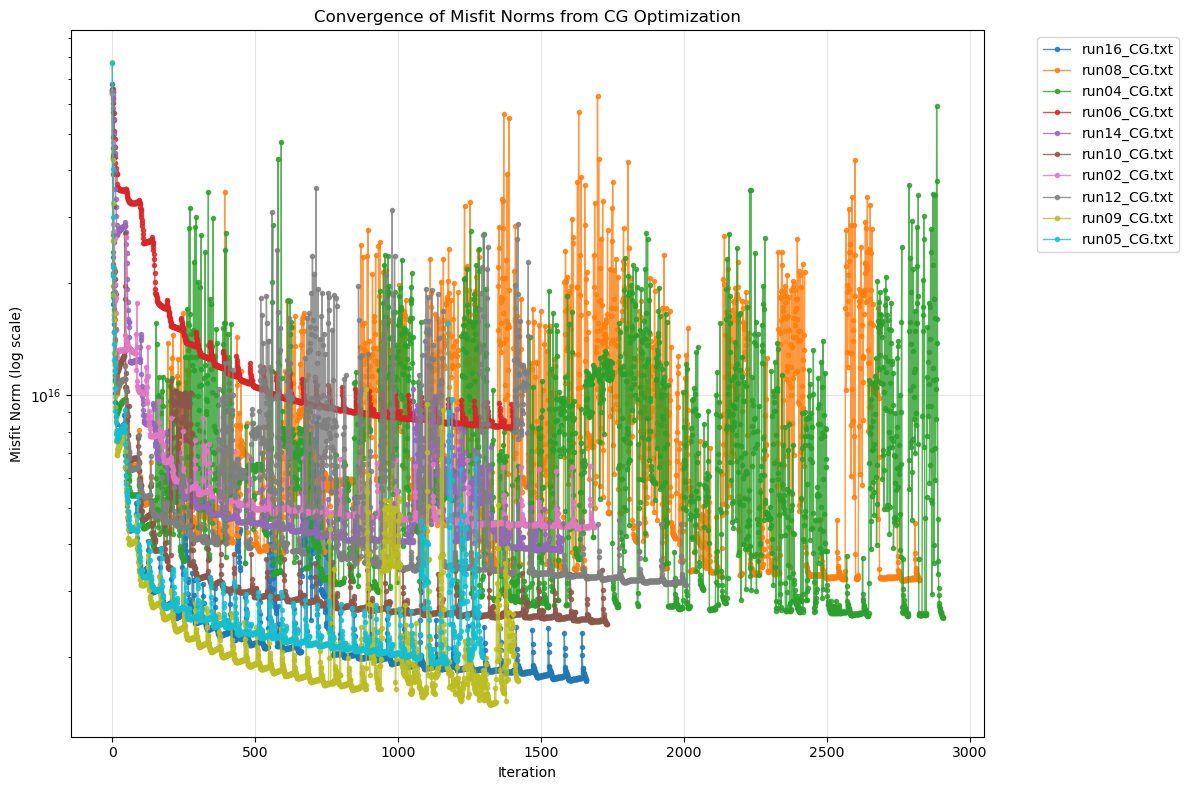


Convergence Statistics for ||fm(x)||^2:
--------------------------------------------------------------------------------
Filename             Iters  Initial      Final        Reduction  Converged 
--------------------------------------------------------------------------------
run16_CG.txt         1659   6.80e+16     1.72e+15     39.5       False
run08_CG.txt         2824   6.37e+16     3.20e+15     19.9       False
run04_CG.txt         2906   6.42e+16     2.55e+15     25.2       False
run06_CG.txt         1413   6.53e+16     8.40e+15     7.8        False
run14_CG.txt         1574   6.49e+16     4.11e+15     15.8       False
run10_CG.txt         1731   6.59e+16     2.45e+15     26.9       False
run02_CG.txt         1687   6.41e+16     4.44e+15     14.4       False
run12_CG.txt         2006   6.50e+16     3.11e+15     20.9       False
run09_CG.txt         1420   7.76e+16     1.72e+15     45.0       False
run05_CG.txt         1298   7.74e+16     2.01e+15     38.6       False
run07_CG.tx

In [10]:
def parse_cgoptimize_line(line: str) -> dict | None:
    """
    Parse a single CGOptimize line and extract all norm values.
    
    Example line:
    "CGOptimize iteration 1 ||f'(x)||^2 = 1.14828e+22 ||fm(x)||^2 = 4.14777e+16 ||fp(x)||^2 = 3.5087e+13 ||fm(x)||^2 + ||fp(x)||^2 = 4.15128e+16 ||fm(x)||^2/||fm_old(x)||^2 = 0.618044"
    
    Returns:
        Dictionary with extracted values or None if line doesn't match
    """
    # Regex patterns for different components
    patterns = {
        'iteration': r'CGOptimize\s+iteration\s+(\d+)',
        'f_prime_norm': r"\|\|f'\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)",
        'fm_norm': r'\|\|fm\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)',
        'fp_norm': r'\|\|fp\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)',
        'fm_fp_sum': r'\|\|fm\(x\)\|\|\^2\s*\+\s*\|\|fp\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d+)',
        'fm_ratio': r'\|\|fm\(x\)\|\|\^2/\|\|fm_old\(x\)\|\|\^2\s*=\s*([+-]?\d+\.?\d*[eE]?[+-]?\d*)'
    }
    
    result = {}
    
    for key, pattern in patterns.items():
        match = re.search(pattern, line)
        if match:
            try:
                if key == 'iteration':
                    result[key] = int(match.group(1))
                else:
                    result[key] = float(match.group(1))
            except ValueError:
                continue
    
    return result if result else None

def extract_detailed_cgoptimize_data(cg_directory: str = "~/Downloads/CG") -> Dict[str, Dict]:
    """
    Extract detailed CGOptimize data including all norm components.
    
    Returns:
        Dictionary mapping filename to extracted data with iterations and norm values
    """
    cg_path = Path(cg_directory).expanduser()
    detailed_data = {}
    
    if not cg_path.exists():
        print(f"Directory {cg_path} does not exist")
        return detailed_data
    
    for file_path in cg_path.iterdir():
        if file_path.is_file():
            try:
                print(f"Processing file: {file_path.name}")
                
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                
                file_data = {
                    'iterations': [],
                    'f_prime_norms': [],
                    'fm_norms': [],
                    'fp_norms': [],
                    'fm_fp_sums': [],
                    'fm_ratios': []
                }
                
                cgoptimize_lines = 0
                for line in lines:
                    if 'CGOptimize iteration' in line:
                        cgoptimize_lines += 1
                        parsed = parse_cgoptimize_line(line.strip())
                        if parsed:
                            file_data['iterations'].append(parsed.get('iteration', 0))
                            file_data['f_prime_norms'].append(parsed.get('f_prime_norm', None))
                            file_data['fm_norms'].append(parsed.get('fm_norm', None))
                            file_data['fp_norms'].append(parsed.get('fp_norm', None))
                            file_data['fm_fp_sums'].append(parsed.get('fm_fp_sum', None))
                            file_data['fm_ratios'].append(parsed.get('fm_ratio', None))
                
                if cgoptimize_lines > 0:
                    detailed_data[file_path.name] = file_data
                    print(f"  Found {cgoptimize_lines} CGOptimize lines")
                    print(f"  ||fm(x)||^2 values: {len([x for x in file_data['fm_norms'] if x is not None])}")
                else:
                    print(f"  No CGOptimize lines found")
                    
            except Exception as e:
                print(f"Error processing {file_path.name}: {e}")
    
    return detailed_data

# Extract detailed CGOptimize data
print("Extracting detailed CGOptimize data...")
detailed_cg_data = extract_detailed_cgoptimize_data()

# Create a simplified dictionary with just fm_norms for backward compatibility
cg_misfit_norms_detailed = {}
for filename, data in detailed_cg_data.items():
    fm_norms = [x for x in data['fm_norms'] if x is not None]
    if fm_norms:
        cg_misfit_norms_detailed[filename] = fm_norms

print(f"\nExtracted ||fm(x)||^2 values from {len(cg_misfit_norms_detailed)} files:")
for filename, norms in cg_misfit_norms_detailed.items():
    print(f"{filename}: {len(norms)} values")
    if norms:
        print(f"  Range: {min(norms):.2e} to {max(norms):.2e}")
        print(f"  Final value: {norms[-1]:.2e}")

# Plot convergence curves and show statistics
if cg_misfit_norms_detailed:
    plot_misfit_convergence(cg_misfit_norms_detailed)
    
    # Calculate and display convergence statistics
    convergence_stats = get_convergence_stats(cg_misfit_norms_detailed)
    
    print("\nConvergence Statistics for ||fm(x)||^2:")
    print("-" * 80)
    print(f"{'Filename':<20} {'Iters':<6} {'Initial':<12} {'Final':<12} {'Reduction':<10} {'Converged':<10}")
    print("-" * 80)
    
    for filename, stats in convergence_stats.items():
        print(f"{filename:<20} {stats['iterations']:<6} {stats['initial_norm']:<12.2e} "
              f"{stats['final_norm']:<12.2e} {stats['reduction_factor']:<10.1f} {stats['converged']}")
else:
    print("No misfit norms extracted. Check if files exist and contain the expected CGOptimize patterns.")


Excluding run08_CG.txt
Excluding run04_CG.txt
Excluding run12_CG.txt
Excluding run01_CG.txt
Excluding run13_CG.txt
Plotting 11 files (excluded 5 files)


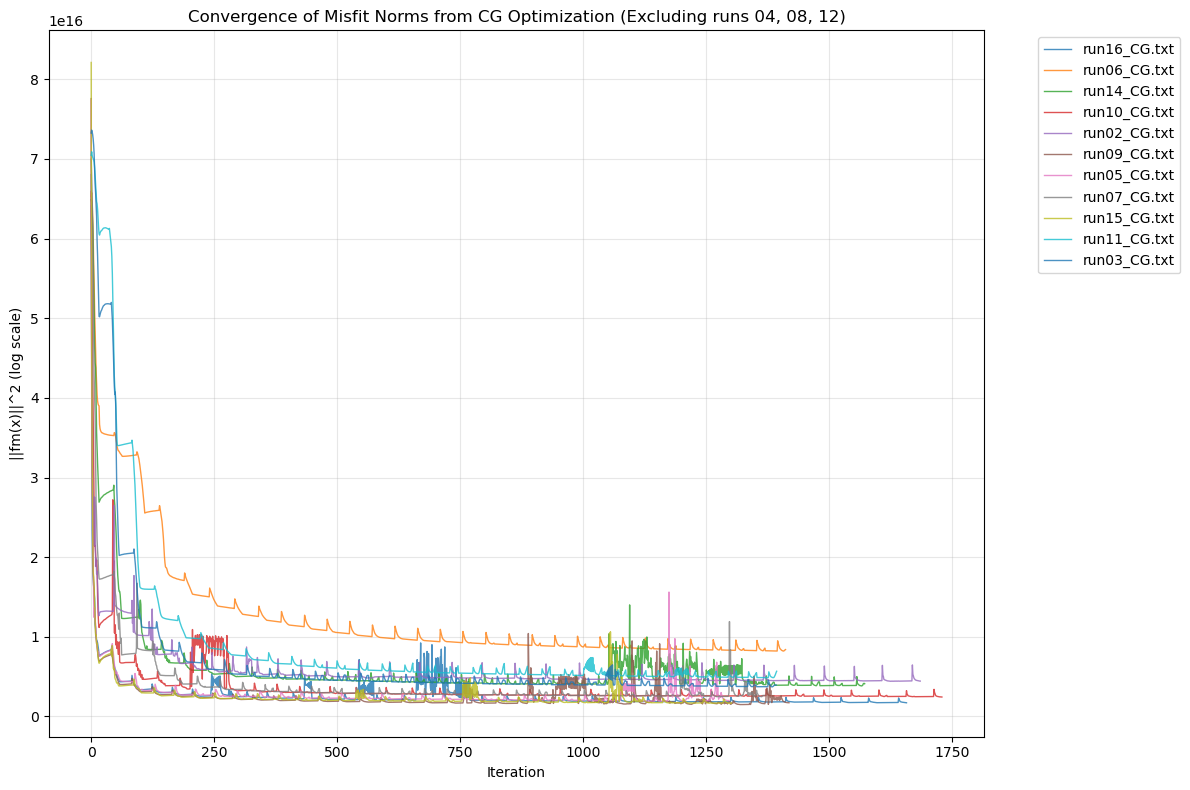


Convergence Statistics (excluding runs 04, 08, 12):
--------------------------------------------------------------------------------
Filename             Iters  Initial      Final        Reduction  Converged 
--------------------------------------------------------------------------------
run16_CG.txt         1659   6.80e+16     1.72e+15     39.5       False
run06_CG.txt         1413   6.53e+16     8.40e+15     7.8        False
run14_CG.txt         1574   6.49e+16     4.11e+15     15.8       False
run10_CG.txt         1731   6.59e+16     2.45e+15     26.9       False
run02_CG.txt         1687   6.41e+16     4.44e+15     14.4       False
run09_CG.txt         1420   7.76e+16     1.72e+15     45.0       False
run05_CG.txt         1298   7.74e+16     2.01e+15     38.6       False
run07_CG.txt         1370   7.00e+16     2.64e+15     26.5       False
run15_CG.txt         1303   8.21e+16     1.69e+15     48.7       False
run11_CG.txt         1395   7.04e+16     5.68e+15     12.4       False

In [18]:
# Plot convergence curves excluding specific runs
def plot_misfit_convergence_filtered(misfit_norms: Dict[str, List[float]], 
                                   exclude_runs: List[str] | None = None, 
                                   max_plots: int = 20):
    """
    Plot convergence curves for misfit norms, excluding specified runs.
    
    Args:
        misfit_norms: Dictionary of filename -> list of norm values
        exclude_runs: List of run identifiers to exclude (e.g., ['04', '08', '12'])
        max_plots: Maximum number of files to plot
    """
    if not misfit_norms:
        print("No misfit norms to plot")
        return
    
    if exclude_runs is None:
        exclude_runs = []
    
    # Filter out excluded runs
    filtered_norms = {}
    for filename, norms in misfit_norms.items():
        # Check if filename contains any of the excluded run numbers
        should_exclude = False
        for exclude_run in exclude_runs:
            if f"run{exclude_run}" in filename.lower() or f"_{exclude_run}_" in filename or f"{exclude_run}." in filename:
                should_exclude = True
                break
        
        if not should_exclude:
            filtered_norms[filename] = norms
        else:
            print(f"Excluding {filename}")
    
    print(f"Plotting {len(filtered_norms)} files (excluded {len(misfit_norms) - len(filtered_norms)} files)")
    
    plt.figure(figsize=(12, 8))
    
    # Plot up to max_plots files
    files_to_plot = list(filtered_norms.keys())[:max_plots]
    
    for filename in files_to_plot:
        norms = filtered_norms[filename]
        iterations = range(len(norms))
        plt.plot(iterations, norms, 
                    linewidth=1, label=filename, alpha=0.8)
    
    plt.xlabel('Iteration')
    plt.ylabel('||fm(x)||^2 (log scale)')
    plt.title('Convergence of Misfit Norms from CG Optimization (Excluding runs 04, 08, 12)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot excluding runs 04, 08, and 12
if cg_misfit_norms_detailed:
    plot_misfit_convergence_filtered(cg_misfit_norms_detailed, exclude_runs=['01', '04', '08', '12', '13'])
    
    # Also show statistics for the filtered data
    filtered_norms = {}
    exclude_runs = ['04', '08', '12']
    
    for filename, norms in cg_misfit_norms_detailed.items():
        should_exclude = False
        for exclude_run in exclude_runs:
            if f"run{exclude_run}" in filename.lower() or f"_{exclude_run}_" in filename or f"{exclude_run}." in filename:
                should_exclude = True
                break
        
        if not should_exclude:
            filtered_norms[filename] = norms
    
    if filtered_norms:
        convergence_stats_filtered = get_convergence_stats(filtered_norms)
        
        print(f"\nConvergence Statistics (excluding runs {', '.join(exclude_runs)}):")
        print("-" * 80)
        print(f"{'Filename':<20} {'Iters':<6} {'Initial':<12} {'Final':<12} {'Reduction':<10} {'Converged':<10}")
        print("-" * 80)
        
        for filename, stats in convergence_stats_filtered.items():
            print(f"{filename:<20} {stats['iterations']:<6} {stats['initial_norm']:<12.2e} "
                  f"{stats['final_norm']:<12.2e} {stats['reduction_factor']:<10.1f} {stats['converged']}")
else:
    print("No misfit norms available for plotting")


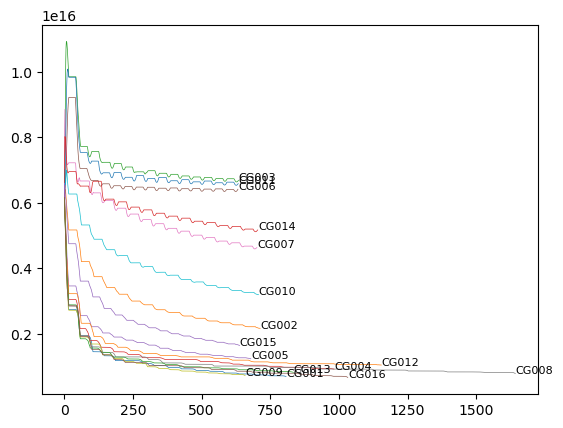

In [16]:
from phd.local.lib.CG import get_fm_fp
CG = Path("/Users/jonniebarnsley/Downloads/CG")


for file in sorted(CG.iterdir()):
    fm, fp = get_fm_fp(file)
    plt.plot(fp, label=file.stem, lw=0.5)
    plt.text(len(fp), fp[-1], file.stem, fontsize=8, ha='left')

#plt.legend()

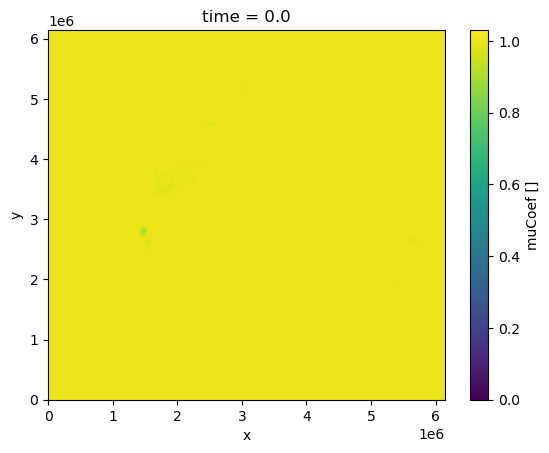

In [18]:
file = xr.open_dataset('/Users/jonniebarnsley/Downloads/ppe_run006_muCoef_0lev.nc')
file.isel(time=-1).muCoef.plot(vmin=0)